In [176]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import KFold
import torch.nn as nn
# Define the FastF1Dataset class
class FastF1Dataset(Dataset):
    def __init__(self, data, sequence_length):
        self.data = data
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.data) - self.sequence_length + 1

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx:idx + self.sequence_length], dtype=torch.float32)

# Load your saved model
def load_model(model_path, model_class, sequence_length, input_dim, device):
    model = model_class(sequence_length, input_dim)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    return model

# Calculate reconstruction error
def compute_reconstruction_error(inputs, outputs):
    return torch.mean((inputs - outputs) ** 2, dim=1).detach().numpy()


# Define your autoencoder class
class LSTMAutoencoder(nn.Module):
    def __init__(self, sequence_length, num_features):
        super(LSTMAutoencoder, self).__init__()
        self.encoder = nn.LSTM(num_features, 64, batch_first=True)
        self.latent = nn.LSTM(64, 32, batch_first=True)
        self.decoder = nn.LSTM(32, 64, batch_first=True)
        self.output_layer = nn.Linear(64, num_features)

    def forward(self, x):
        x, _ = self.encoder(x)
        x, _ = self.latent(x[:, -1].unsqueeze(1).repeat(1, x.size(1), 1))
        x, _ = self.decoder(x)
        x = self.output_layer(x)
        return x

# Set paths and parameters
model_path = "AD_19-23_autoencoder_AdamW_lr0001_loss0.4037_fold5.pth"
new_data_path = "2024_LasVegasGrandPrix_GAS_MinMaxScaler_normalized_complete_wPits.npz"
sequence_length = 20
threshold = 500

# Load the new data
new_data = np.load(new_data_path, allow_pickle=True)['data']
new_data_array = np.array(new_data, dtype=np.float32)

# Create the test dataset and data loader
test_dataset = FastF1Dataset(new_data_array, sequence_length)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Load the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = new_data_array.shape[1]  # Number of features per timestep
autoencoder = load_model(model_path, LSTMAutoencoder, sequence_length, input_dim, device).to(device)

# Test the model
def test_autoencoder(autoencoder, data_loader, device):
    autoencoder.eval()
    errors = []

    with torch.no_grad():
        for batch in data_loader:
            inputs = batch.to(device)
            outputs = autoencoder(inputs)
            batch_errors = compute_reconstruction_error(inputs, outputs)
            errors.extend(batch_errors)

    return np.array(errors)

reconstruction_errors = test_autoencoder(autoencoder, test_loader, device)

# Set a threshold for anomalies


In [177]:
#new_data (npz) to pandas
import pandas as pd
race_df = pd.DataFrame(new_data)

cols = [
       'Time_in_ms',
       'LapTime_in_ms',
       'LapNumber',
       'Position',
       'Speed',
       'AirTemp',
       'Humidity',
       'Pressure',
       'TrackTemp',
       'WindDirection',
       'WindSpeed',
       'DistanceToDriverAhead',
       'RPM',
       'nGear',
       'Throttle',
       'X', 
       'Y', 
       'Z', 
       'Distance', 
       'TyreLife',
       'Compound',
       'Team',
       'TrackStatus',
       'Rainfall',
       'DriverAhead',
       'Brake',
       'DRS',
       'Event'
    ]

race_df.columns = cols
#first 50 rows of tyrelife
race_df

,Time_in_ms,LapTime_in_ms,LapNumber,Position,Speed,AirTemp,Humidity,Pressure,TrackTemp,WindDirection,...,Distance,TyreLife,Compound,Team,TrackStatus,Rainfall,DriverAhead,Brake,DRS,Event
0,0.003932,0.381304,0.0,0.0,0.008403,1.0,1.0,1.0,0.711111,1.000000,...,0.000000,0.000000,2.0,3.0,1.0,0.0,11.0,0.0,0.0,22.0
1,0.005778,0.381304,0.0,0.0,0.030812,1.0,1.0,1.0,0.711111,1.000000,...,0.000169,0.000000,2.0,3.0,1.0,0.0,81.0,0.0,0.0,22.0
2,0.006164,0.381304,0.0,0.0,0.039216,1.0,1.0,1.0,0.711111,1.000000,...,0.000211,0.000000,2.0,3.0,1.0,0.0,81.0,0.0,0.0,22.0
3,0.007881,0.381304,0.0,0.0,0.047619,1.0,1.0,1.0,0.711111,1.000000,...,0.000430,0.000000,2.0,3.0,1.0,0.0,81.0,0.0,0.0,22.0
4,0.008525,0.381304,0.0,0.0,0.058824,1.0,1.0,1.0,0.711111,1.000000,...,0.000530,0.000000,2.0,3.0,1.0,0.0,4.0,0.0,0.0,22.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11461,0.948928,0.701522,1.0,1.0,0.210084,0.0,0.0,1.0,0.000000,0.612121,...,0.996373,0.444444,3.0,3.0,1.0,0.0,30.0,0.0,0.0,22.0
11462,0.950980,0.701522,1.0,1.0,0.210084,0.0,0.0,1.0,0.000000,0.612121,...,0.997223,0.444444,3.0,3.0,1.0,0.0,30.0,0.0,0.0,22.0
11463,0.950988,0.701522,1.0,1.0,0.210084,0.0,0.0,1.0,0.000000,0.612121,...,0.997227,0.444444,3.0,3.0,1.0,0.0,30.0,0.0,0.0,22.0
11464,0.952525,0.701522,1.0,1.0,0.210084,0.0,0.0,1.0,0.000000,0.612121,...,0.997869,0.444444,3.0,3.0,1.0,0.0,30.0,0.0,0.0,22.0


<Axes: >

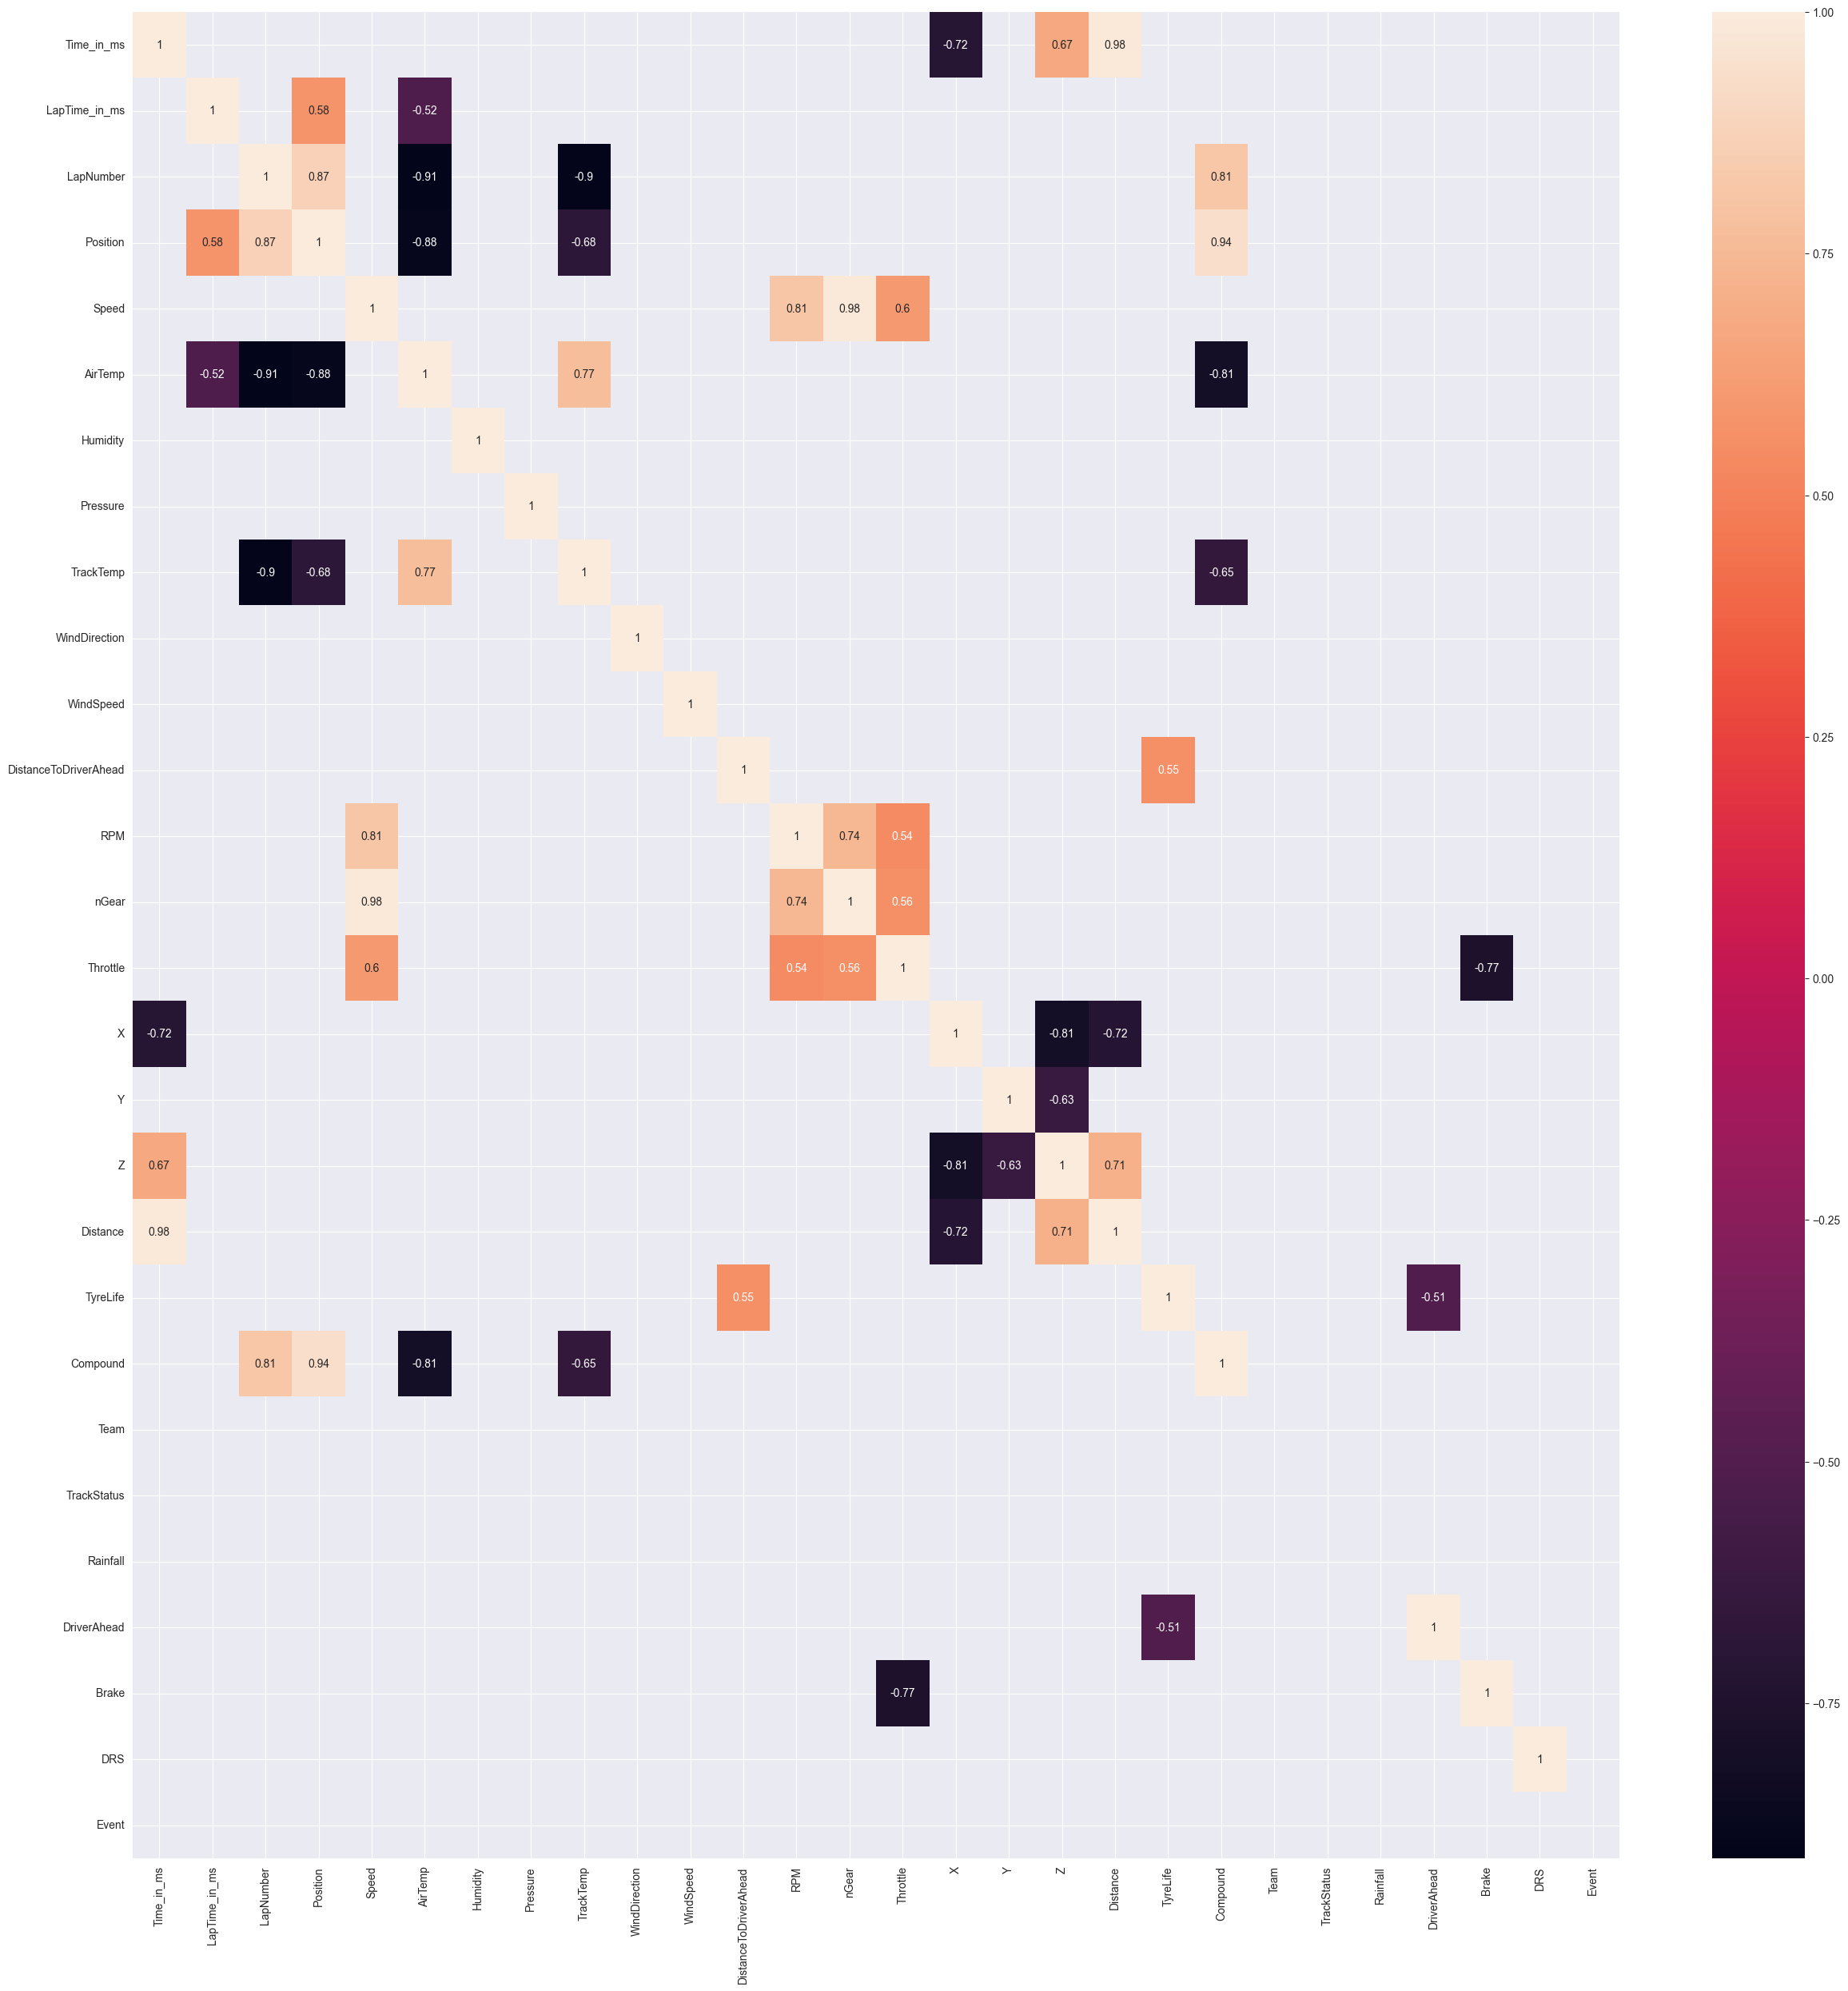

In [178]:
import seaborn as sns
correlation_matrix = race_df.corr()
#filter the correlation matrix to only show correlations above 0.5 and below -0.5
mask = correlation_matrix >0.5
mask2 = correlation_matrix <-0.5
filtered = correlation_matrix[mask | mask2]
#very big heatmap
plt.figure(figsize=(30, 30))

sns.heatmap(filtered, annot=True,)

In [179]:
len(new_data)

11466

In [211]:
    def plot_reconstruction_errors_with_threshold(errors, threshold=None):
        """
        Plots reconstruction errors as a line graph with an optional threshold.
    
        Parameters:
            errors (np.array): Array of reconstruction errors.
            threshold (float, optional): Threshold for detecting anomalies. Defaults to None.
        """
        plt.figure(figsize=(30, 12))
        plt.plot(errors, label="Reconstruction Errors", color='blue', linewidth=4)
        
        if threshold is not None:
            plt.axhline(y=threshold, color='red', linestyle='--', label="Threshold", linewidth=4)
        
        plt.xlabel("Sample Index", fontsize=40)
        plt.xticks(range(0, len(errors), 1000), fontsize=35)
        plt.yticks(fontsize=35)
        plt.ylabel("Reconstruction Error", fontsize=40)
        # plt.title("Reconstruction Errors with Threshold", fontsize=30)
        
        # Aggiungi legenda una sola volta
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        #change legend font size
        plt.legend(by_label.values(), by_label.keys(), prop={'size': 35})
        plt.subplots_adjust(left=0.07, right=0.93, top=0.9, bottom=0.1)
        #show the axis
        plt.axvline(x=0, color='black', linewidth=2)
        plt.axhline(y=0, color='black', linewidth=2)
        
        plt.grid(alpha=0.3)
        plt.savefig("reconstruction_errors.png")
        plt.show()

In [207]:
# threshold = np.mean(reconstruction_errors) + 3 * np.std(reconstruction_errors)
threshold = np.percentile(reconstruction_errors, 99.9)

# Visualize errors
# visualize_reconstruction_errors(reconstruction_errors, threshold=threshold)

# Print anomalies
anomalies = reconstruction_errors > threshold
print(f"Total anomalies detected: {np.sum(anomalies)}")

Total anomalies detected: 321


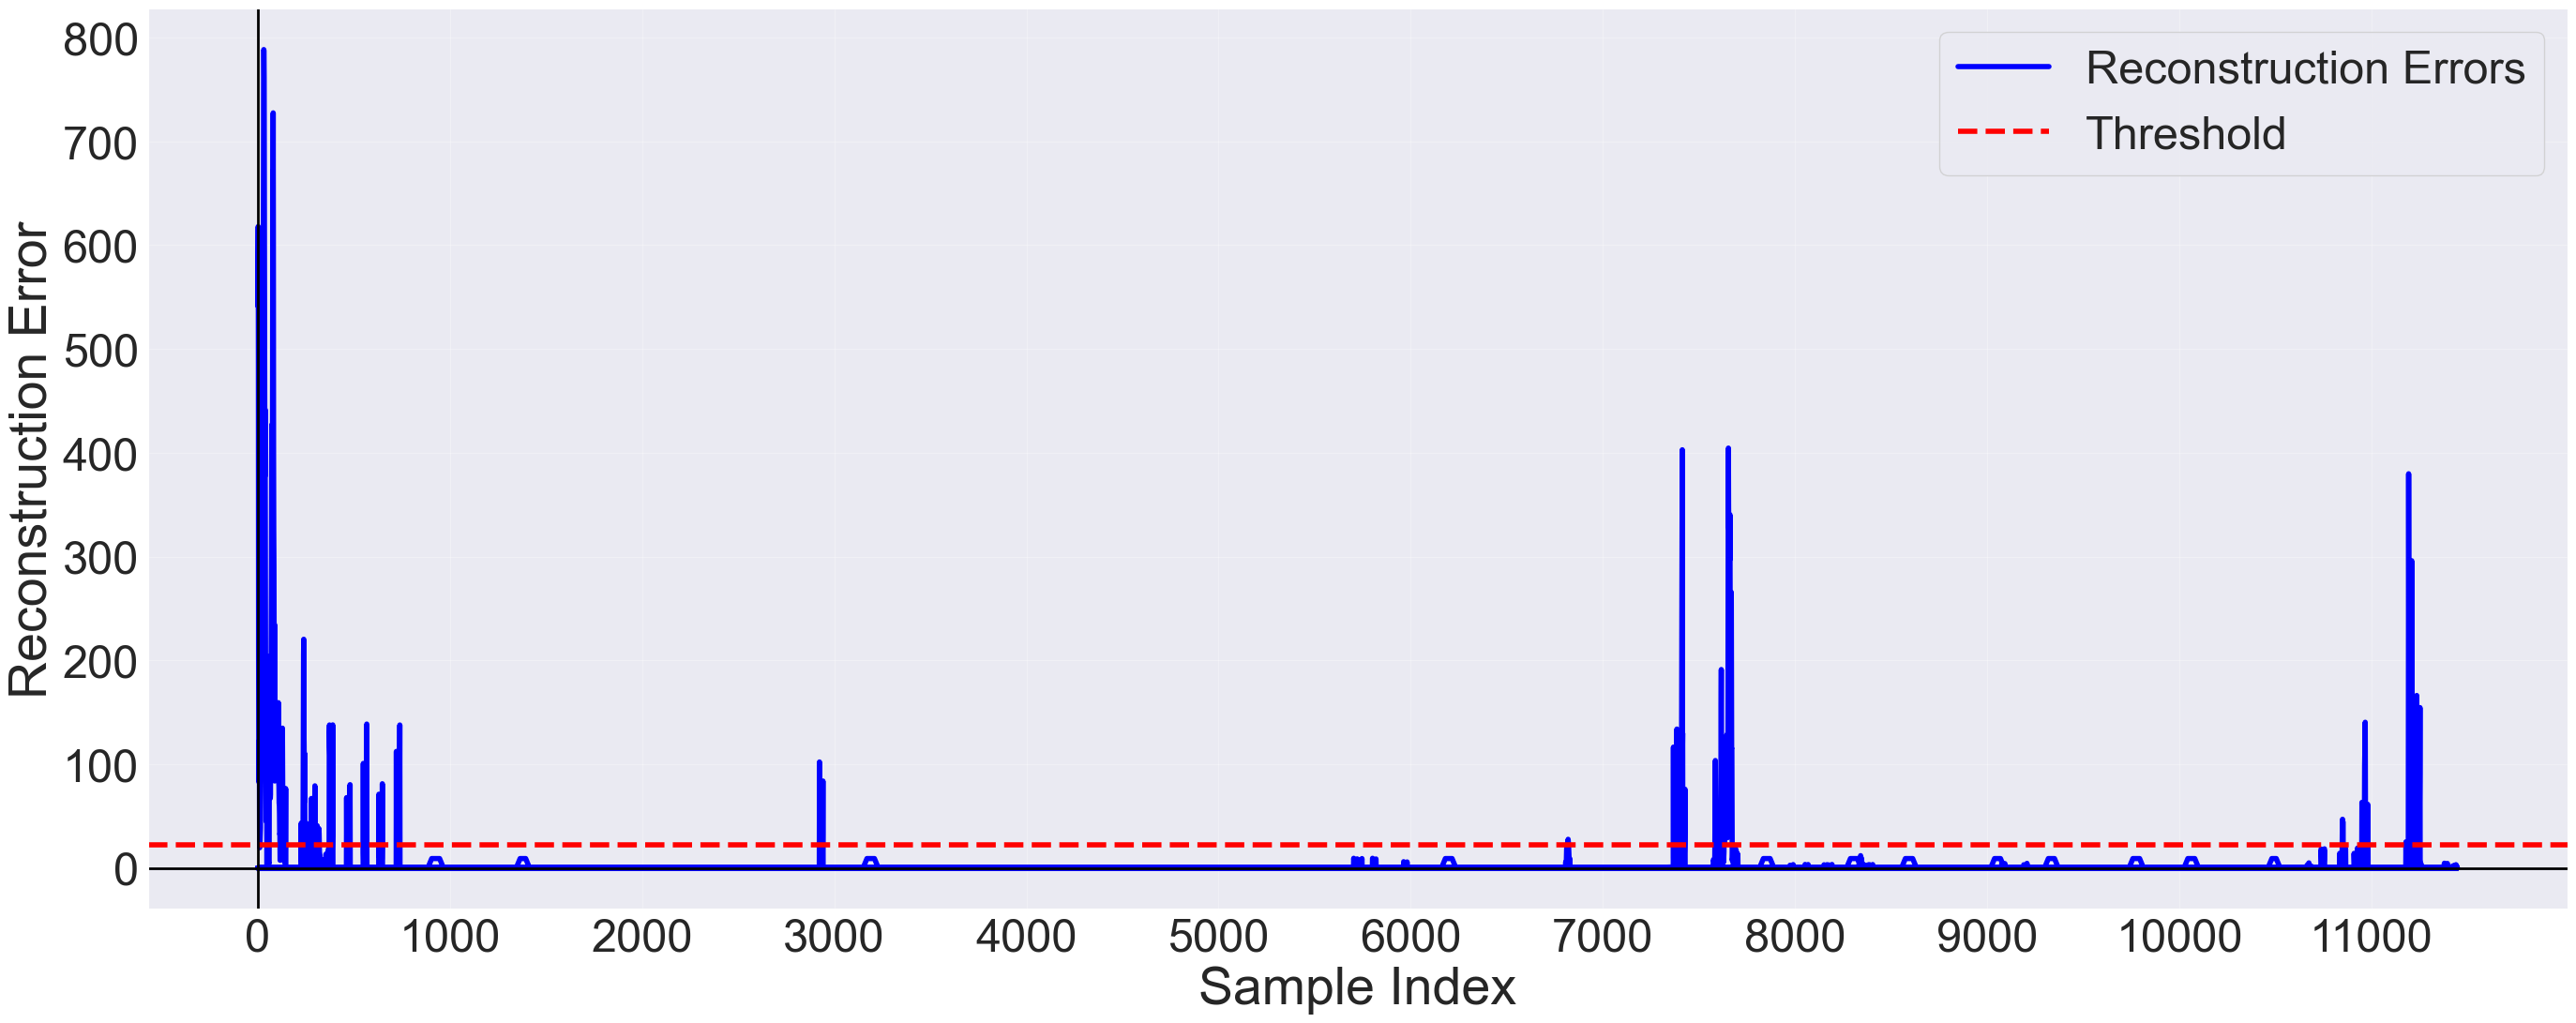

In [212]:
plot_reconstruction_errors_with_threshold(reconstruction_errors, threshold=threshold)

In [183]:
# Find the indexes where anomalies are True
indexes = np.where(anomalies == True)[0]

# Group consecutive True blocks, allowing gaps of up to 5
blocks = []
block = []

for i in range(len(indexes)):
    if not block or indexes[i] <= block[-1] + 200:
        # Start a new block or extend the current one
        block.append(indexes[i])
    else:
        # Close the current block and start a new one
        blocks.append(block)
        block = [indexes[i]]

# Append the last block
if block:
    blocks.append(block)

print(blocks)


[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 138, 139, 144, 145, 226, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 253, 254, 279, 280, 286, 287, 296, 297, 302, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 388, 389, 390, 462, 463, 469, 479, 480, 549, 565, 566, 567, 630, 647, 648, 721, 737, 738, 739], [2923, 2940, 2941], [6816, 6817, 6818, 6819, 6820, 6821], [7367, 7383, 7384, 7385, 7397, 7409, 7410, 7411, 7412, 7413, 7414, 7415, 7425, 7426, 7427, 7583, 7584, 75

In [184]:
len(blocks)

5

In [185]:
minutes_to_exlude = 5 # around first 3 laps
# Exclude first laps
first_lap_sequences = int((minutes_to_exlude * 60 * 1000) / 240)  # (minutes_to_exlude in milliseconds / length of a row)
count = 0
for block in blocks:
    if len(block) > 1:
        if block[0] > first_lap_sequences:
            print(f"Anomaly detected from timestep {block[0]}, with len {len(block)+20}")
            count += 1
print(f"Total anomalies detected: {count}")

Anomaly detected from timestep 2923, with len 23
Anomaly detected from timestep 6816, with len 26
Anomaly detected from timestep 7367, with len 99
Anomaly detected from timestep 10847, with len 67
Total anomalies detected: 4


In [186]:
last_anomaly = blocks[-1][0] - 200
race_df[last_anomaly:]

,Time_in_ms,LapTime_in_ms,LapNumber,Position,Speed,AirTemp,Humidity,Pressure,TrackTemp,WindDirection,...,Distance,TyreLife,Compound,Team,TrackStatus,Rainfall,DriverAhead,Brake,DRS,Event
10647,0.833605,0.105109,0.928571,0.642857,0.843137,0.315789,0.0,1.0,0.0,0.757576,...,0.952696,0.333333,3.0,3.0,1.0,0.0,22.0,0.0,0.0,22.0
10648,0.836009,0.105109,0.928571,0.642857,0.843137,0.315789,0.0,1.0,0.0,0.757576,...,0.956563,0.333333,3.0,3.0,1.0,0.0,22.0,0.0,0.0,22.0
10649,0.836352,0.105109,0.928571,0.642857,0.845938,0.315789,0.0,1.0,0.0,0.757576,...,0.957117,0.333333,3.0,3.0,1.0,0.0,22.0,0.0,0.0,22.0
10650,0.837726,0.105109,0.928571,0.642857,0.848740,0.315789,0.0,1.0,0.0,0.757576,...,0.959334,0.333333,3.0,3.0,1.0,0.0,22.0,0.0,0.0,22.0
10651,0.837898,0.105109,0.928571,0.642857,0.848740,0.315789,0.0,1.0,0.0,0.757576,...,0.959611,0.333333,3.0,3.0,1.0,0.0,22.0,0.0,0.0,22.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11461,0.948928,0.701522,1.000000,1.000000,0.210084,0.000000,0.0,1.0,0.0,0.612121,...,0.996373,0.444444,3.0,3.0,1.0,0.0,30.0,0.0,0.0,22.0
11462,0.950980,0.701522,1.000000,1.000000,0.210084,0.000000,0.0,1.0,0.0,0.612121,...,0.997223,0.444444,3.0,3.0,1.0,0.0,30.0,0.0,0.0,22.0
11463,0.950988,0.701522,1.000000,1.000000,0.210084,0.000000,0.0,1.0,0.0,0.612121,...,0.997227,0.444444,3.0,3.0,1.0,0.0,30.0,0.0,0.0,22.0
11464,0.952525,0.701522,1.000000,1.000000,0.210084,0.000000,0.0,1.0,0.0,0.612121,...,0.997869,0.444444,3.0,3.0,1.0,0.0,30.0,0.0,0.0,22.0


In [187]:
#check speed variance through windows
speed = race_df['Speed']
rpm = race_df['RPM']
speed_anomaly = speed[last_anomaly:]
rpm_anomaly = rpm[last_anomaly:]

max_threshold = 80/280
min_threshold = 80/370

#create a window of 20 samples that monitors the variance of the speed
speed_mean = []
rpm_var = []
speed_entry = False
for i in range(len(speed_anomaly)-20):
    speed_mean.append(np.mean(speed_anomaly[i:i+20]))
    rpm_var.append(np.var(rpm_anomaly[i:i+20]))
    if speed_mean[-1] > min_threshold and speed_mean[-1] < max_threshold and not speed_entry \
        and rpm_var[-1] < 0.002:
        # print(speed_var[-1])
        print(f"PIT ENTRY at index {i+last_anomaly}")
        speed_entry = True

# speed_var

# plt.figure(figsize=(24, 6))
# plt.plot(speed_mean, label="Speed Variance", color='blue', linewidth=1.5)
# # plt.plot(list(speed_anomaly), label="Speed", color='red', linewidth=1.5)
# plt.xlabel("Sample Index")
# race_df[last_anomaly:]

PIT ENTRY at index 10703


In [188]:
rpm_var

[1.1672118489514105e-05,
 1.3049500921624713e-05,
 2.5118226403719746e-05,
 4.867243842454627e-05,
 6.267132266657427e-05,
 7.191365148173645e-05,
 7.872214337112382e-05,
 8.3650738815777e-05,
 8.620644075563177e-05,
 8.627347415313125e-05,
 8.226939098676667e-05,
 8.564165909774601e-05,
 0.00010700451821321622,
 0.00015133130364120007,
 0.00016198081721086055,
 0.0001574447815073654,
 0.00015450238424818963,
 0.00014113078941591084,
 0.00011672636173898354,
 8.55705511639826e-05,
 0.0001959574146894738,
 0.00032568772439844906,
 0.00047443766379728913,
 0.0005139164859429002,
 0.0005049565224908292,
 0.0005128227639943361,
 0.0005327750695869327,
 0.0005681567708961666,
 0.0005560921272262931,
 0.0006126560037955642,
 0.0009202972869388759,
 0.0016640030080452561,
 0.0018849257612600923,
 0.0023227122146636248,
 0.002982302103191614,
 0.003847595304250717,
 0.005624213255941868,
 0.007997043430805206,
 0.010895421728491783,
 0.013591766357421875,
 0.016762446612119675,
 0.019726503640